In [0]:
import os
import torch
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from torch.autograd import Variable
from sklearn import manifold

In [0]:
#%% Define paths

data_root_dir = '../datasets'

In [3]:
# Set device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# GPU
useCuda = False
if torch.cuda.is_available():
  useCuda = True
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
print('I use cuda:',useCuda)

I use cuda: True


# Colab instructions

If I am using Colab, the path is specified.

In [0]:
Colab = True

In [5]:
if Colab:
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/ComputationalNeuroscience/HW4/'
else:
  path = '' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Parameters of the Processes

In [0]:
# Processes
RandomSearchTrain = False # Perform the random search
EmbSpacesTrain = False # Perform the training showing the dependence on the embedded space dimension
FinalTrain = False # Final training for the a specific dimension
DenFinalTrain = False # Final training for the denoising autoencoder
VAEFinalTrain=False # Training for Variational Autencoder

# Dataset

The dataset is built and divided into train, validation and test.

-----------------------------------------
Size of the training set: 48000
Size of the validation set: 12000
Size of the test set: 10000
-----------------------------------------




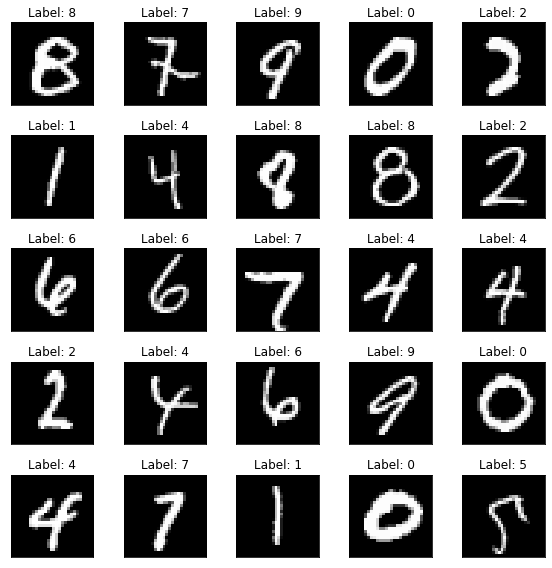

In [7]:
### Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

torch.manual_seed(int(17))
train_dim = int(len(train_dataset)*0.8)
val_dim = len(train_dataset)-train_dim
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_dim, val_dim])

print('-----------------------------------------')
print('Size of the training set:',len(train_dataset))
print('Size of the validation set:',len(val_dataset))
print('Size of the test set:',len(test_dataset))
print('-----------------------------------------')
print('\n')

### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Model

The class autoencoder is defined. The encoded dimension is a free parameter.

In [0]:
#%% Define the network architecture

class Autoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Training

Define training functions.

In [0]:
#%% Network training

### Training function
def train_epoch(net, dataloader, loss_fn, optimizer):
    # Training
    net.train()

    lt = []
    for sample_batch in dataloader:
        # Extract data and move tensors to the selected device
        image_batch = sample_batch[0].to(device)
        # Forward pass
        output = net(image_batch)
        loss = loss_fn(output, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))
        lt.append(float(loss.data))
    
    return np.mean(np.array(lt))


### Testing function
def test_epoch(net, dataloader, loss_fn):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out = net(image_batch)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out])
            conc_label = torch.cat([conc_label, image_batch]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return float(val_loss.data)


def training(net, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs, verbose):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        ### Training
        tl = train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer) 
        train_loss.append(tl)
        ### Validation
        vl = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn)
        val_loss.append(vl) 

        if verbose and (epoch+1)%10==0:
          # Print losses
          print('EPOCH %d/%d' % (epoch + 1, num_epochs))
          print('TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss[epoch]))
          print('VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss[epoch]))
          # Plot progress
          img = val_dataset[0][0].unsqueeze(0).to(device)
          net.eval()
          with torch.no_grad():
              rec_img  = net(img)
          fig, axs = plt.subplots(1, 2, figsize=(12,6))
          axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[0].set_title('Original image')
          axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
          plt.tight_layout()
          plt.pause(0.1)
          # Save figures
          os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
          plt.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
          plt.show()
          plt.close()

        if (epoch+1 % 10 == 0):
          # Save network parameters
          torch.save(net.state_dict(), path+'net_params.pth')

        # Early stopping
        if epoch > 10:
          k = 0
          for i in range(10):
            if val_loss[epoch-i]>val_loss[epoch-i-1]: k+=1
          if k>=8:
            # Save final weights
            torch.save(net.state_dict(), path+'net_params.pth')
            print('Stop due to early stopping!')
            break


    # Save final weights
    torch.save(net.state_dict(), path+'net_params.pth')

    # Plot losses 
    plt.plot(train_loss,label='Training')
    plt.plot(val_loss, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig(path+'training.png')
    plt.show()

    return train_loss, val_loss

# Cross validation

The grid search is performed using the _k_-fold cross validation.

In [0]:
def CrossValidation(train_dataset, folds, lr, weight_decay):
  
  print('----------------------------')
  print('Learning rate:', lr)
  print('Weight decay:', weight_decay)

  # Encoded space dimension to perform cross validation
  encoded_space_dim = 6

  # Split and train
  kf = KFold(n_splits=folds,random_state=0, shuffle=True)
  kf.get_n_splits(train_dataset)

  loss = 0
  cv = 0
  for train_index, test_index in kf.split(train_dataset):
      print('********')
      print('Fold:', cv+1) 
      # Define the network 
      net = Autoencoder(encoded_space_dim=encoded_space_dim)
      net.to(device)
      # Define the optimizer
      optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
      # Define loss function
      loss_fn = torch.nn.MSELoss()
      # K fold
      ktrain = torch.utils.data.Subset(train_dataset, train_index)
      ktest= torch.utils.data.Subset(train_dataset, test_index)
      ktrain_dataloader = DataLoader(ktrain, batch_size=512, shuffle=True)
      ktest_dataloader = DataLoader(ktest, batch_size=512, shuffle=False)
      # Perform training
      tloss, vloss = training(net, ktrain_dataloader, ktest_dataloader, loss_fn, optimizer, 15, False)
      loss += vloss[-1]
      cv += 1
      
  print('********')
  final_loss = loss/folds
  print('Loss:', final_loss)
  print('----------------------------')
  print('\n')

  return final_loss
  

def RandomSearch(train_dataset, folds, configurations):
  
  # Possible values
  lr_list= [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
  weight_decay_list = [1e-05,2e-05,3e-05,4e-05,5e-05,6e-05,7e-05,8e-05,9e-05,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001]

  # Selected values
  lr_sel = np.random.choice(lr_list,configurations)
  weight_sel = np.random.choice(weight_decay_list,configurations)

  parameters = []
  for lr, weight_decay in zip(lr_sel,weight_sel):
      loss = CrossValidation(train_dataset, folds, lr, weight_decay)
      parameters.append([lr,weight_decay,loss])

  return parameters

In [0]:
if RandomSearchTrain:
  par = RandomSearch(train_dataset, 4, 35)
  print(par)

In [12]:
# Two dimensions

results = [[0.004, 1e-05, 0.04401384169856707], [0.0006, 0.0004, 0.06382679442564647], [0.001, 5e-05, 0.05242076019446055],[0.006, 0.0001, 0.04629781097173691], [0.006, 0.0005, 0.06290854265292485], [0.0005, 0.0006, 0.06500589350859325],[0.01, 0.0005, 0.06232525780797005], [0.0002, 0.0008, 0.06697265803813934], [0.002, 0.0006, 0.06331222256024678],[0.0007, 0.0006, 0.06452345848083496], [0.0002, 5e-05, 0.061901417871316276], [0.0009, 0.0007, 0.06483579178651173],[0.006, 8e-05, 0.04450481633345286], [0.0008, 1e-05, 0.052415343622366585], [0.0009, 7e-05, 0.05391048391660055],[0.006, 3e-05, 0.04241941620906194], [0.0002, 7e-05, 0.06339521085222562], [0.0007, 0.0002, 0.06306252876917522],[0.005, 1e-05, 0.043498557060956955], [0.01, 9e-05, 0.04546808451414108], [0.0003, 4e-05, 0.059310266127189],[0.002, 3e-05, 0.045342426747083664], [0.0009, 0.0004, 0.06327766180038452], [0.003, 8e-05, 0.04770899564027786],[0.0007, 0.0002, 0.06245059644182523], [0.001, 3e-05, 0.05101024483640989], [0.006, 0.0008, 0.06369230896234512],[0.005, 0.0006, 0.06308914224306743], [0.001, 3e-05, 0.05167585238814354], [0.004, 2e-05, 0.04338442534208298]]
results = np.array(results).reshape(len(results),3)
loss = results[:,2]

# Taking the minumum loss
best = np.argmin(loss)
best = results[best]

# Best values
lr = best[0]
weight_decay = best[1]

print('-----------------------------')
print('Best configurations')
print('Learning rate:',lr)
print('Weight decay:',weight_decay)
print('Loss:',best[2])
print('-----------------------------')

-----------------------------
Best configurations
Learning rate: 0.006
Weight decay: 3e-05
Loss: 0.04241941620906194
-----------------------------


In [13]:
# Results of the random search
results=[[0.009, 0.001, 0.06413725018501282], [0.0001, 0.0004, 0.06471815519034863], [0.001, 0.0001, 0.03030332550406456],[0.0006, 0.0009, 0.06399725563824177], [0.0009, 0.0009, 0.06450815685093403], [0.0001, 4e-05, 0.04187264572829008],[0.001, 6e-05, 0.025013715494424105], [0.01, 3e-05, 0.02379088429734111], [0.002, 9e-05, 0.025349993258714676],[0.0004, 6e-05, 0.030146189965307713], [0.006, 4e-05, 0.024403325282037258], [0.0008, 0.0008, 0.06370279006659985],[0.0004, 0.0008, 0.06378892250359058], [0.0005, 1e-05, 0.02594916196539998], [0.01, 3e-05, 0.0241332552395761],[0.0003, 3e-05, 0.028803722467273474], [0.0008, 8e-05, 0.026818543206900358], [0.002, 0.0008, 0.06359454616904259],[0.01, 0.0006, 0.06312127131968737], [0.009, 7e-05, 0.024969012942165136], [0.0008, 8e-05, 0.03693830594420433],[0.008, 0.0004, 0.06241914164274931], [0.0007, 3e-05, 0.025597181636840105], [0.008, 1e-05, 0.023594302590936422],[0.004, 2e-05, 0.02289631776511669], [0.0002, 0.0007, 0.06504518911242485], [0.0001, 0.0001, 0.054107293486595154],[0.0005, 0.0001, 0.03208069084212184], [0.01, 0.0005, 0.06233844440430403], [0.003, 0.0009, 0.06406525708734989],[0.0006, 0.0001, 0.03113295743241906], [0.0007, 0.0006, 0.06298293825238943], [0.0009, 0.0002, 0.060451189056038857],[0.0003, 0.0006, 0.0634794645011425], [0.0006, 0.0006, 0.06292101927101612]]
results = np.array(results).reshape(len(results),3)
loss = results[:,2]

# Taking the minumum loss
best = np.argmin(loss)
best = results[best]

# Best values
lr = best[0]
weight_decay = best[1]

print('-----------------------------')
print('Best configurations')
print('Learning rate:',lr)
print('Weight decay:',weight_decay)
print('Loss:',best[2])
print('-----------------------------')

-----------------------------
Best configurations
Learning rate: 0.004
Weight decay: 2e-05
Loss: 0.02289631776511669
-----------------------------


# Final training considering different encoded space dimension

Given the best couples of learning rate and weight decay, it is studided how the size of the hidden layer (latent code) affects reconstruction performance.


In [0]:
# Build dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

In [0]:
# Considered encoded space dimensions
if EmbSpacesTrain:

  encoded_space_dim_list = [2,4,6,8,10,15,20,30]
  results = []
  for encoded_space_dim in encoded_space_dim_list:
    # Define network
    net = Autoencoder(encoded_space_dim=encoded_space_dim)
    net.to(device)
    # Define the optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    # Define loss function
    loss_fn = torch.nn.MSELoss()
    train_loss, val_loss = training(net, train_dataloader, val_dataloader, loss_fn, optimizer, 80, False)
    test_loss = test_epoch(net, test_dataloader, loss_fn)
    results.append([encoded_space_dim,test_loss])

  print(results)

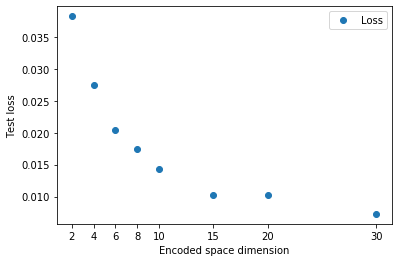

In [0]:
# Plot of the results
results = [[2, 0.03822643682360649],[4, 0.027419304475188255],[6, 0.020345531404018402], [8, 0.017370063811540604], [10, 0.01434781588613987], [15, 0.010321153327822685], [20, 0.010194934904575348], [30, 0.007281699683517218]]
results = np.array(results).reshape(8,2)
plt.plot(results[:,0],results[:,1], 'o',label='Loss')
plt.xlabel('Encoded space dimension')
plt.ylabel('Test loss')
plt.legend()
plt.xticks(results[:,0])
plt.savefig(path+'SizeVSLoss.png')
plt.show()

# Fix the encoded space dimension to 6

The final training with the fixed encoded space dimension is performed and then the model is tested with corrupted images.

In [16]:
# Define the structure
encoded_space_dim = 6
# Define the network
net = Autoencoder(encoded_space_dim=encoded_space_dim)

if FinalTrain:
  net.to(device)
  # Define the optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
  # Define loss function
  loss_fn = torch.nn.MSELoss()
  train_loss, val_loss = training(net, train_dataloader, val_dataloader, loss_fn, optimizer, 80, True)

# Load network parameters    
net.load_state_dict(torch.load(path+'net_params_6.pth', map_location='cpu'))

<All keys matched successfully>

Build the corrupted images.

In [0]:
# Class for the Gaussian Noise
class GaussianNoise(object):

  def __init__(self, mean, std):
    self.std = std
    self.mean = mean
        
  def __call__(self, image):
    # noise = random values * std + mean
    noise = (torch.randn(image.size())*self.std+self.mean).cpu()
    #new image = noise + image
    new = noise+image
    return new
    
# Class for the Broken images
class Broken(object):

  def __init__(self):
    self.size = np.random.randint(5,14,1)[0]

  def __call__(self, image):
    back_ground = torch.ones(image.size()).cpu()
    limx = np.random.randint(0,image.size()[1]-self.size,1)[0]
    limy = np.random.randint(0,image.size()[2]-self.size,1)[0]
    back_ground[:,limx:limx+self.size,limy:limy+self.size] = 0
    new = image*back_ground
    return new

In [0]:
class NoisyDataset(Dataset):
  
  def __init__(self,clean,transform):
    self.clean=clean
    self.transform=transform

  def __len__(self):
    return len(self.clean)
  
  def __getitem__(self,idx):

    noisy_img=self.clean[idx][0]
    noisy_img=self.transform(noisy_img)
    clean_img=self.clean[idx][0]
    label = self.clean[idx][1]
      
    return clean_img, noisy_img, label

In [0]:
### Testing function
def noisy_test_epoch(net, dataloader, loss_fn):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for clean_sample_batch, noisy_sample_batch, l in dataloader:
            # Extract data and move tensors to the selected device
            clean_image_batch = clean_sample_batch.to(device)
            noisy_image_batch = noisy_sample_batch.to(device)
            # Forward pass
            out = net(noisy_image_batch)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out])
            conc_label = torch.cat([conc_label, clean_image_batch]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return float(val_loss.data)

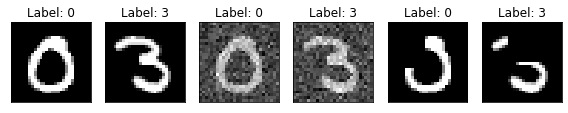

In [0]:
# Build the dataset
gaussian_test_dataset = NoisyDataset(test_dataset,GaussianNoise(0,0.2))
broken_test_dataset   = NoisyDataset(test_dataset,Broken())

# Build dataloader
gaussian_test_dataloader = DataLoader(gaussian_test_dataset,  batch_size=512, shuffle=False)
broken_test_dataloader = DataLoader(broken_test_dataset,  batch_size=512, shuffle=False)

# Show some samples

plt.close('all')
fig, axs = plt.subplots(1, 6, figsize=(8,4))
idx = np.random.randint(0,10000,2)

for i in range(2):
    axs[i].imshow(test_dataset[idx[i]][0].squeeze().numpy(), cmap='gist_gray')
    axs[i].set_title('Label: %d' % test_dataset[idx[i]][1])
    axs[i].set_xticks([])
    axs[i].set_yticks([])
for i in range(2):
    axs[i+2].imshow(gaussian_test_dataset[idx[i]][1].squeeze().numpy(), cmap='gist_gray')
    axs[i+2].set_title('Label: %d' % gaussian_test_dataset[idx[i]][2])
    axs[i+2].set_xticks([])
    axs[i+2].set_yticks([])
for i in range(2):
    axs[i+4].imshow(broken_test_dataset[idx[i]][1].squeeze().numpy(), cmap='gist_gray')
    axs[i+4].set_title('Label: %d' % broken_test_dataset[idx[i]][2])
    axs[i+4].set_xticks([])
    axs[i+4].set_yticks([])

plt.savefig(path+'test.png')
plt.tight_layout()
plt.show()

In [0]:
# Compute the loss

# Define loss function
loss_fn = torch.nn.MSELoss()

net.to(device)

# Test on the original images
test_loss = test_epoch(net, test_dataloader, loss_fn)
# Gaussian
gaussian_test_loss = noisy_test_epoch(net, gaussian_test_dataloader, loss_fn)
# Broken
broken_test_loss = noisy_test_epoch(net, broken_test_dataloader, loss_fn)

In [0]:
print('-------------------------------------------------------')
print('Loss on normal test dataset:',test_loss)
print('Loss on gaussian test dataset:',gaussian_test_loss)
print('Loss on broken test dataset:',broken_test_loss)
print('-------------------------------------------------------')

-------------------------------------------------------
Loss on normal test dataset: 0.020764615386724472
Loss on gaussian test dataset: 0.022689415141940117
Loss on broken test dataset: 0.06035621836781502
-------------------------------------------------------


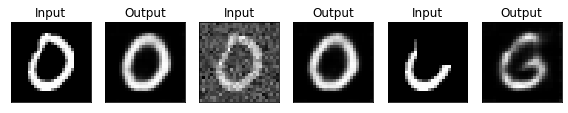

In [0]:
plt.close('all')
fig, axs = plt.subplots(1, 6, figsize=(8,4))
idx = np.random.randint(0,10000,1)[0]

test = test_dataset[idx][0].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test = net(test)
axs[0].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Input')
axs[1].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Output')
test = gaussian_test_dataset[idx][1].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test = net(test)
axs[2].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].set_title('Input')
axs[3].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[3].set_title('Output')
test = broken_test_dataset[idx][1].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test = net(test)
axs[4].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[4].set_title('Input')
axs[5].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[5].set_title('Output')
for i in range(6):
  axs[i].set_xticks([])
  axs[i].set_yticks([])


plt.savefig(path+'out.png')
plt.tight_layout()
plt.show()

In [0]:
# Different level of noise
gaussian_test_loss = []

# Define loss function
loss_fn = torch.nn.MSELoss()

net.to(device)

level = np.arange(0,1,0.1)
for i in level:
  # Build the dataset 
  gaussian_test_dataset = NoisyDataset(test_dataset,GaussianNoise(0,i))

  # Build dataloader
  gaussian_test_dataloader = DataLoader(gaussian_test_dataset,  batch_size=512, shuffle=False)

  # Gaussian
  gaussian_test_loss.append(noisy_test_epoch(net, gaussian_test_dataloader, loss_fn))

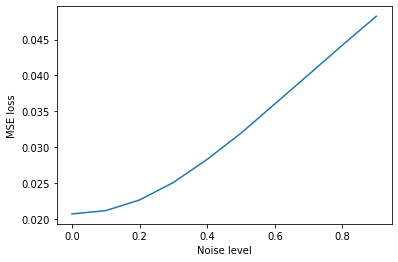

In [28]:
plt.plot(level, gaussian_test_loss)
plt.xlabel('Noise level')
plt.ylabel('MSE loss')
plt.savefig(path+'noise.png')
plt.show()

Network analysis.

In [0]:
### Get the encoded representation of the test samples

def Space(net,vae=False):
  net.cpu()
  samples = []
  labels = []
  plotall = []
  for sample in tqdm(test_dataset):
      img = sample[0].unsqueeze(0)
      label = sample[1]
      # Encode image
      net.eval()
      if vae:
        with torch.no_grad():
            mu, log_var  = net.encode(img)
        # Append to list
        std = log_var.mul(0.5).exp_()
        elements = torch.randn(mu.size()).cpu()*std+mu
        samples.append(elements.flatten().numpy())
        labels.append(label)
        plotall.append((elements.flatten().numpy(),label))
      else:
        with torch.no_grad():
            encoded_img  = net.encode(img)
        # Append to list
        samples.append(encoded_img.flatten().numpy())
        labels.append(label)
        plotall.append((encoded_img.flatten().numpy(),label))

  samples = np.array(samples)
  tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
  X_tsne = tsne.fit_transform(samples)

  encoded_samples = [(X_tsne[x],labels[x]) for x in range(len(test_dataset))]

  ### Visualize encoded space
  color_map = {
          0: '#1f77b4',
          1: '#ff7f0e',
          2: '#2ca02c',
          3: '#d62728',
          4: '#9467bd',
          5: '#8c564b',
          6: '#e377c2',
          7: '#7f7f7f',
          8: '#bcbd22',
          9: '#17becf'
          }

  # Plot just 5k points
  encoded_samples_reduced = random.sample(encoded_samples, 2000)
  fig, ax = plt.subplots(figsize=(5,5))

  for enc_sample, label in tqdm(encoded_samples_reduced):
      ax.plot(enc_sample[0], enc_sample[1], marker='.', color=color_map[label])
      ax.set_xlabel('Coordinate 1')
      ax.set_ylabel('Coordinate 2')
      ax.grid(True)
      ax.legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
  plt.tight_layout()
  plt.show()

  encoded_samples_reduced = random.sample(plotall, 1000)
  fig, ax = plt.subplots(1,3,figsize=(15,5))

  for i in range(0,6,2):
    j = int(i/2)
    for enc_sample, label in tqdm(encoded_samples_reduced):
        ax[j].plot(enc_sample[i], enc_sample[i+1], marker='.', color=color_map[label])
        ax[j].set_xlabel('Coordinate '+str(i+1))
        ax[j].set_ylabel('Coordinate '+str(i+2))
        ax[j].grid(True)
        ax[j].legend([plt.Line2D([0], [0], ls='', marker='.', color=c, label=l) for l, c in color_map.items()], color_map.keys())
  plt.tight_layout()
  plt.show()

100%|██████████| 2000/2000 [00:29<00:00, 66.68it/s]


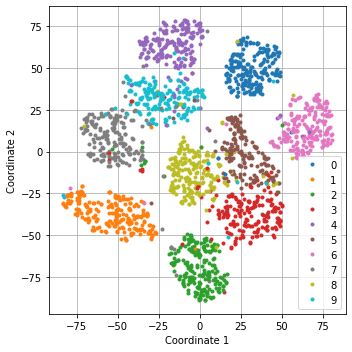

100%|██████████| 1000/1000 [00:13<00:00, 73.32it/s]


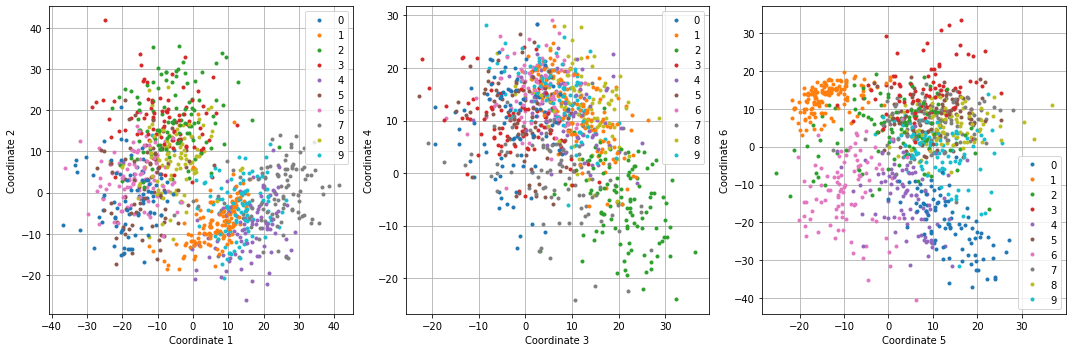

In [0]:
Space(net)

# Denoising autoencoder

The corrupted dataset is built and then is performed the training.

In [0]:
def add_noise():
  choice = np.random.randint(0,2,1)[0]
  if choice == 0:
    return GaussianNoise(0,0.5)
  else: 
    return Broken()

In [0]:
class RandomNoisyDataset(Dataset):
  
  def __init__(self,clean):
    self.clean=clean

  def __len__(self):
    return len(self.clean)
  
  def __getitem__(self,idx):

    noisy_img=self.clean[idx][0]
    transform = add_noise()
    noisy_img=transform(noisy_img)
    clean_img=self.clean[idx][0]
    label = self.clean[idx][1]
      
    return clean_img, noisy_img, label

In [0]:
noisy_train_dataset = RandomNoisyDataset(train_dataset)
noisy_val_dataset = RandomNoisyDataset(val_dataset)
noisy_test_dataset = RandomNoisyDataset(test_dataset)

noisy_train_dataloader = DataLoader(noisy_train_dataset,  batch_size=512, shuffle=True)
noisy_val_dataloader = DataLoader(noisy_val_dataset,  batch_size=512, shuffle=False)
noisy_test_dataloader = DataLoader(noisy_test_dataset,  batch_size=512, shuffle=False)

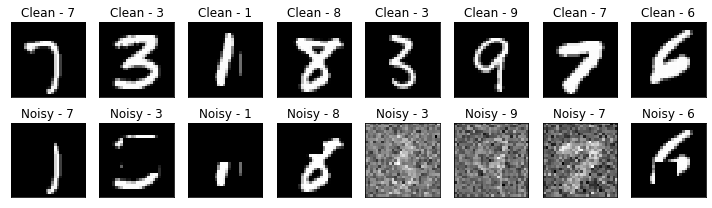

In [24]:
# Gaussian
plt.close('all')
fig, axs = plt.subplots(2, 8, figsize=(10,3))
for i in range(8):
    img, noisy, label = random.choice(noisy_test_dataset)
    axs[0][i].imshow(img.squeeze().numpy(), cmap='gist_gray')
    axs[0][i].set_title('Clean - %d' % label)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])
    axs[1][i].imshow(noisy.squeeze().numpy(), cmap='gist_gray')
    axs[1][i].set_title('Noisy - %d' % label)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])
plt.savefig(path+'dentrain.png')
plt.tight_layout()
plt.show()

Training definition

In [0]:
### Training function
def noisy_train_epoch(net, dataloader, loss_fn, optimizer):

    # Training
    net.train()

    lt = []
    for clean_sample_batch, noisy_sample_batch, l in dataloader:
        # Extract data and move tensors to the selected device
        clean_image_batch = clean_sample_batch.to(device)
        noisy_image_batch = noisy_sample_batch.to(device)
        # Forward pass
        output = net(noisy_image_batch)
        loss = loss_fn(output, clean_image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))
        lt.append(float(loss.data))
    
    return np.mean(np.array(lt))


### Testing function
def noisy_test_epoch(net, dataloader, loss_fn):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        conc_out = torch.Tensor().float()
        conc_label = torch.Tensor().float()
        for clean_sample_batch, noisy_sample_batch, l in dataloader:
            # Extract data and move tensors to the selected device
            clean_image_batch = clean_sample_batch.to(device)
            noisy_image_batch = noisy_sample_batch.to(device)
            # Forward pass
            out = net(noisy_image_batch)
            # Concatenate with previous outputs
            conc_out = torch.cat([conc_out, out])
            conc_label = torch.cat([conc_label, clean_image_batch]) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return float(val_loss.data)


def noisy_training(net, noisy_train_dataloader, noisy_test_dataloader, loss_fn, optimizer, num_epochs, verbose):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        ### Training
        tl = noisy_train_epoch(net, noisy_train_dataloader, loss_fn, optimizer)
        train_loss.append(tl)
        ### Validation
        vl = noisy_test_epoch(net, noisy_test_dataloader, loss_fn)
        val_loss.append(vl) 

        if verbose and (epoch+1)%10==0:
          # Print losses
          print('EPOCH %d/%d' % (epoch + 1, num_epochs))
          print('TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss[epoch]))
          print('VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss[epoch]))
          # Plot progress
          clean_img = noisy_val_dataset[0][0].unsqueeze(0).cpu()
          noisy_img = noisy_val_dataset[0][1].unsqueeze(0).to(device)
          net.eval()
          with torch.no_grad():
              rec_img  = net(noisy_img)
          fig, axs = plt.subplots(1, 3, figsize=(12,6))
          axs[0].imshow(noisy_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[0].set_title('Corrupted image')
          axs[1].imshow(clean_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[1].set_title('Original image')
          axs[2].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[2].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
          plt.tight_layout()
          plt.pause(0.1)
          # Save figures
          os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
          plt.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
          plt.show()
          plt.close()

        if (epoch+1 % 10 == 0):
          # Save network parameters
          torch.save(net.state_dict(), path+'net_params_den_6.pth')

        # Early stopping
        if epoch > 10:
          k = 0
          for i in range(10):
            if val_loss[epoch-i]>val_loss[epoch-i-1]: k+=1
          if k>=8:
            # Save final weights
            torch.save(net.state_dict(), path+'net_params_den_6.pth')
            print('Stop due to early stopping!')
            break


    # Save final weights
    torch.save(net.state_dict(), path+'net_params_den_6.pth')

    # Plot losses 
    plt.plot(train_loss,label='Training')
    plt.plot(val_loss, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig(path+'noisy_training_6.png')
    plt.show()

    return train_loss, val_loss

Final training

In [0]:
# Define the structure
encoded_space_dim = 6
# Define the network
net = Autoencoder(encoded_space_dim=encoded_space_dim)

if DenFinalTrain:
  net.to(device)
  # Define the optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
  # Define loss function
  loss_fn = torch.nn.MSELoss()
  train_loss, val_loss = noisy_training(net, noisy_train_dataloader, noisy_val_dataloader, loss_fn, optimizer, 80, True)

In [0]:
# Build the dataset
gaussian_test_dataset = NoisyDataset(test_dataset,GaussianNoise(0,0.2))
broken_test_dataset   = NoisyDataset(test_dataset,Broken())

# Build dataloader
gaussian_test_dataloader = DataLoader(gaussian_test_dataset,  batch_size=512, shuffle=False)
broken_test_dataloader = DataLoader(broken_test_dataset,  batch_size=512, shuffle=False)

In [0]:
# Define loss function
loss_fn = torch.nn.MSELoss()

# Load network parameters    
net.load_state_dict(torch.load(path+'net_params_den_6.pth', map_location='cpu'))
net.to(device)

# Test on the corr images
test_loss_corr = noisy_test_epoch(net, noisy_test_dataloader, loss_fn)
test_loss_gaussian = noisy_test_epoch(net, gaussian_test_dataloader, loss_fn)
test_loss_broken = noisy_test_epoch(net, broken_test_dataloader, loss_fn)

# Test on the original images
test_loss = test_epoch(net, test_dataloader, loss_fn)

In [29]:
print('----------------------------------------------------')
print('Test loss on the corrupted dataset:', test_loss_corr)
print('Test loss on the gaussian dataset:', test_loss_gaussian)
print('Test loss on the broken dataset:', test_loss_broken)
print('Test loss on the original dataset:', test_loss)
print('----------------------------------------------------')

----------------------------------------------------
Test loss on the corrupted dataset: 0.02550361678004265
Test loss on the gaussian dataset: 0.022446781396865845
Test loss on the broken dataset: 0.026903679594397545
Test loss on the original dataset: 0.02226065658032894
----------------------------------------------------


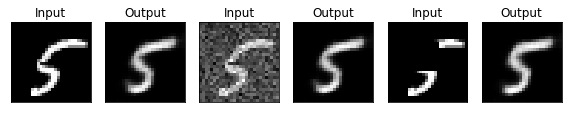

In [67]:
plt.close('all')
fig, axs = plt.subplots(1, 6, figsize=(8,4))
idx = np.random.randint(0,10000,1)[0]

test = test_dataset[idx][0].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test = net(test)
axs[0].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Input')
axs[1].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Output')
test = gaussian_test_dataset[idx][1].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test = net(test)
axs[2].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2].set_title('Input')
axs[3].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[3].set_title('Output')
test = broken_test_dataset[idx][1].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test = net(test)
axs[4].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[4].set_title('Input')
axs[5].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[5].set_title('Output')
for i in range(6):
  axs[i].set_xticks([])
  axs[i].set_yticks([])

plt.savefig(path+'outden.png')
plt.tight_layout()
plt.show()

In [0]:
# Different level of noise
gaussian_test_loss = []

# Define loss function
loss_fn = torch.nn.MSELoss()

net.to(device)

level = np.arange(0,1,0.1)
for i in level:
  # Build the dataset 
  gaussian_test_dataset = NoisyDataset(test_dataset,GaussianNoise(0,i))

  # Build dataloader
  gaussian_test_dataloader = DataLoader(gaussian_test_dataset,  batch_size=512, shuffle=False)

  # Gaussian
  gaussian_test_loss.append(noisy_test_epoch(net, gaussian_test_dataloader, loss_fn))

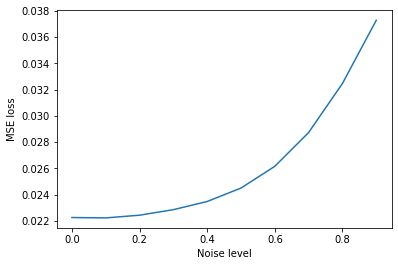

In [69]:
plt.plot(level, gaussian_test_loss)
plt.xlabel('Noise level')
plt.ylabel('MSE loss')
plt.savefig(path+'noiseden.png')
plt.show()

100%|██████████| 2000/2000 [00:20<00:00, 97.26it/s]


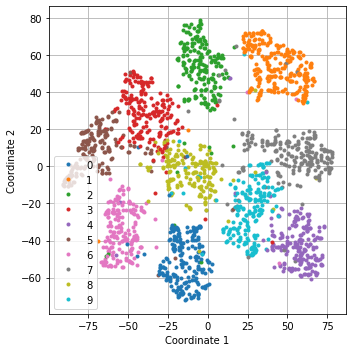

100%|██████████| 1000/1000 [00:10<00:00, 101.21it/s]


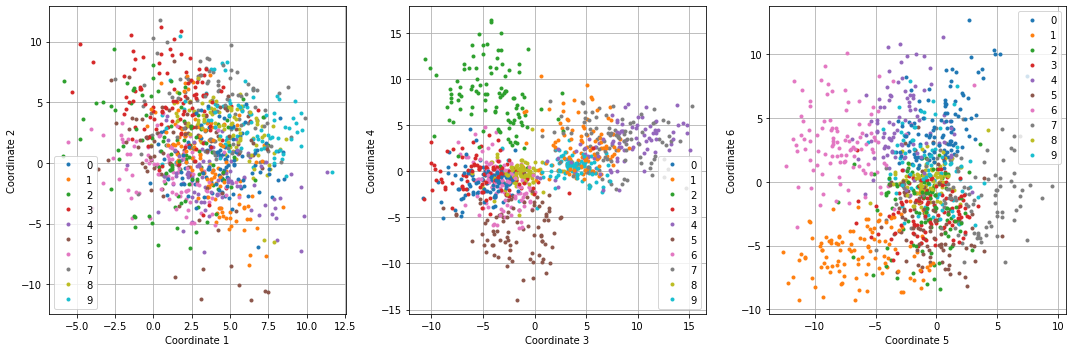

In [70]:
Space(net)

# Generative capabilities

In [0]:
def Generate(net,encoded_space_dim,vae=False):

  fig, axs = plt.subplots(10,10,figsize=(7,7))
  fig.subplots_adjust(wspace=0,hspace=0)
  net.cpu()
  net.eval()
  for i in range(10):
    for j in range(10):
      if vae: 
        kind = 'vae'
        with torch.no_grad():
          temp = np.random.randint(0,4,1)[0]
          coordinates = torch.randn((encoded_space_dim,)).float().unsqueeze(0).cpu()#.add(temp)
          out = net.decode(coordinates)
          axs[i][j].imshow(out.cpu().squeeze().numpy(), cmap='gist_gray')
      else:
        kind = 'org'
        with torch.no_grad():
          coordinates = np.random.randint(-5,5,encoded_space_dim)
          coordinates[0] = np.random.randint(-2.5,10,1)[0]
          coordinates = torch.from_numpy(coordinates).float().unsqueeze(0).cpu()
          out = net.decode(coordinates)
          axs[i][j].imshow(out.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i][j].set_xticks([])
      axs[i][j].set_yticks([])
  plt.savefig(path+str(kind)+'generation.png')

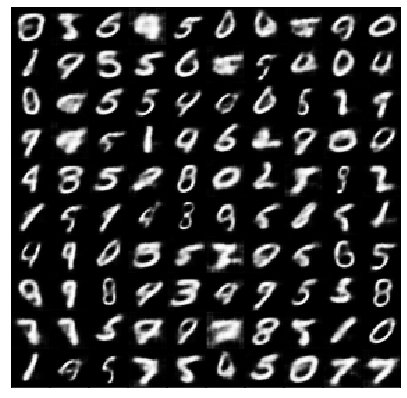

In [83]:
Generate(net,6)

In [0]:
def Transitions(net, input_start, input_finish, vae=False):

  # Get the labels
  label = np.array([x[1] for x in test_dataset])

  # Get the index of the sample
  start = np.random.choice(np.argwhere(label==input_start).squeeze())
  # Get the starting sample
  start = test_dataset[start][0].unsqueeze(0)

  # Get the index of the sample
  finish = np.random.choice(np.argwhere(label==input_finish).squeeze())
  # Get the final sample
  finish = test_dataset[finish][0].unsqueeze(0)


  # Plot start and finish
  fig, axs = plt.subplots(1,2,figsize=(2.8,2))
  fig.subplots_adjust(wspace=0)
  axs[0].imshow(start.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[0].set_title('Start: '+str(input_start))
  axs[1].imshow(finish.cpu().squeeze().numpy(), cmap='gist_gray')
  axs[1].set_title('Finish: '+str(input_finish))
  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

  print('\n')

  # Goes from start to finish
  net.eval()
  if vae:
    kind = 'vae'
    with torch.no_grad():
      mu, log_var  = net.encode(start)
      # Append to list
      std = log_var.mul(0.5).exp_()
      start = torch.randn(mu.size()).cpu()*std+mu
      mu, log_var  = net.encode(finish)
      # Append to list
      std = log_var.mul(0.5).exp_()
      finish = torch.randn(mu.size()).cpu()*std+mu
  
  else:
    kind = 'org'
    with torch.no_grad():
      start  = net.encode(start)
      finish =  net.encode(finish)

  # Step
  step = (finish - start)/9.0
  
  current = start
  fig, axs = plt.subplots(1,10,figsize=(10,3))
  fig.subplots_adjust(wspace=0)

  for i in range(10):
    with torch.no_grad():
      out = net.decode(current)
      axs[i].imshow(out.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i].set_title('Step '+ str(i+1))
      axs[i].set_xticks([])
      axs[i].set_yticks([])
    current += step

  plt.savefig(path+str(kind)+str(input_start)+'to'+str(input_finish)+'.png')

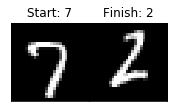

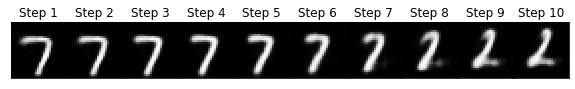

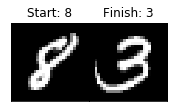

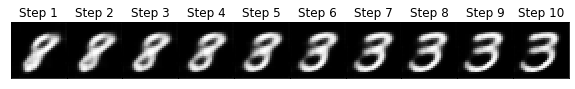

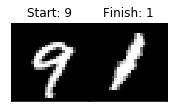

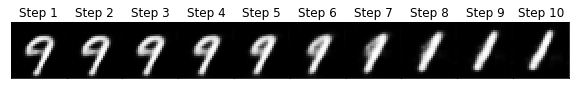

In [85]:
Transitions(net,7,2)
Transitions(net,8,3)
Transitions(net,9,1)

In [0]:
def RandomTransitions(net,encoded_space_dim,vae=False):

  net.cpu()
  net.eval()
  # Plot start and finish
  fig, axs = plt.subplots(1,2,figsize=(2.8,2))
  fig.subplots_adjust(wspace=0)


  if vae: 
    kind = 'vae'
    with torch.no_grad():
      temp = np.random.randint(0,2,2)
      coordinates_start = torch.randn((encoded_space_dim,)).float().unsqueeze(0).cpu().add(temp[0])
      out_start = net.decode(coordinates_start)
      coordinates_finish = torch.randn((encoded_space_dim,)).float().unsqueeze(0).cpu().add(temp[1])
      out_finish = net.decode(coordinates_finish)
      axs[0].imshow(out_start.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Start')
      axs[1].imshow(out_finish.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Finish')

  else:
    kind = 'org'
    with torch.no_grad():
      coordinates_start = torch.randint(-20,20,(encoded_space_dim,)).float().unsqueeze(0).cpu()
      out_start = net.decode(coordinates_start)
      coordinates_finish = torch.randint(-20,20,(encoded_space_dim,)).float().unsqueeze(0).cpu()
      out_finish = net.decode(coordinates_finish)
      axs[0].imshow(out_start.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Start')
      axs[1].imshow(out_finish.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Finish')

  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

  step = (coordinates_finish - coordinates_start)/9.0

  current = coordinates_start
  fig, axs = plt.subplots(1,10,figsize=(10,3))
  fig.subplots_adjust(wspace=0)

  for i in range(10):
    with torch.no_grad():
      out = net.decode(current)
      axs[i].imshow(out.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[i].set_title('Step '+ str(i+1))
      axs[i].set_xticks([])
      axs[i].set_yticks([])
    current += step

  plt.savefig(path+str(kind)+'random_transition.png')

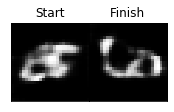

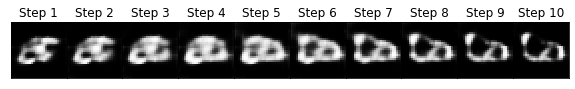

In [89]:
RandomTransitions(net,6)

# Variational Autoencoders

In [0]:
# Build dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=512, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

In [0]:
#%% Define the network architecture

class VariationalAutoencoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        # Linear
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
        )
        # mu
        self.encoder_lin_mu =  nn.Linear(64, encoded_space_dim)  

        # var
        self.encoder_lin_log_var = nn.Linear(64, encoded_space_dim)

        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.parametrize(mu,log_var)
        out = self.decode(z)
        return out, mu, log_var

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        x = self.encoder_lin(x)
        # Apply linear layers
        mu = self.encoder_lin_mu(x)
        log_var = self.encoder_lin_log_var(x)
        return mu, log_var

    def parametrize(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        return torch.randn(mu.size())*std+mu

    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [0]:
#%% Network training

### Loss function for variational autoencoder
def loss_function(output, image_batch, mu, log_var):
  MSE_loss = torch.nn.MSELoss(reduction='none')
  MSE = torch.sum(MSE_loss(output.view(-1, 784),image_batch.view(-1, 784)))
  KLD = 0.5*torch.sum(mu.pow(2)+log_var.exp()-(1+log_var))
  return (MSE+KLD)/(784*512)

#%% Network training

### Training function
def vae_train_epoch(net, dataloader, optimizer):
    # Training
    net.train()

    lt = []
    for sample_batch in dataloader:
        # Extract data and move tensors to the selected device
        image_batch = sample_batch[0].to(device)
        # Forward pass
        output, mu, log_var = net(image_batch)
        loss = loss_function(output, image_batch, mu, log_var)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print loss
        #print('\t partial train loss: %f' % (loss.data))
        lt.append(float(loss.data))
    
    return np.mean(np.array(lt))


### Testing function
def vae_test_epoch(net, dataloader):
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    lv = []
    with torch.no_grad(): # No need to track the gradients
        for sample_batch in dataloader:
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out, mu, log_var = net(image_batch)        
        # Evaluate  loss
            loss = loss_function(out, image_batch, mu, log_var)
            lv.append(float(loss.data))

    return np.mean(np.array(lv))


def vae_training(net, train_dataloader, test_dataloader, optimizer, num_epochs, verbose):
    train_loss = []
    val_loss = []
    beta = 0
    for epoch in range(num_epochs):
        ### Training
        tl = vae_train_epoch(net, dataloader=train_dataloader, optimizer=optimizer) 
        train_loss.append(tl)
        ### Validation
        vl = vae_test_epoch(net, dataloader=test_dataloader)
        val_loss.append(vl) 
        if verbose and (epoch+1)%10==0:
          # Print losses
          print('EPOCH %d/%d' % (epoch + 1, num_epochs))
          print('TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss[epoch]))
          print('VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss[epoch]))
          # Plot progress
          img = val_dataset[0][0].unsqueeze(0).to(device)
          net.eval()
          with torch.no_grad():
              rec_img, _, _  = net(img)
          fig, axs = plt.subplots(1, 2, figsize=(12,6))
          axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[0].set_title('Original image')
          axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
          axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
          plt.tight_layout()
          plt.pause(0.1)
          # Save figures
          os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
          plt.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
          plt.show()
          plt.close()

        if (epoch+1 % 10 == 0):
          # Save network parameters
          torch.save(net.state_dict(), path+'net_params_vae_6.pth')

        # Early stopping
        if epoch > 10:
          k = 0
          for i in range(10):
            if val_loss[epoch-i]>val_loss[epoch-i-1]: k+=1
          if k>=8:
            # Save final weights
            torch.save(net.state_dict(), path+'net_params_vae_6.pth')
            print('Stop due to early stopping!')
            break


    # Save final weights
    torch.save(net.state_dict(), path+'net_params_vae_6.pth')

    # Plot losses 
    plt.plot(train_loss,label='Training')
    plt.plot(val_loss, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.savefig(path+'training_vae_6.png')
    plt.show()

    return train_loss, val_loss

In [0]:
# Define the structure
encoded_space_dim = 6
# Define the network
net = VariationalAutoencoder(encoded_space_dim=encoded_space_dim)

if VAEFinalTrain:
  net.to(device)
  # Define the optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
  # Define loss function
  train_loss, val_loss = vae_training(net, train_dataloader, val_dataloader, optimizer, 80, True)

In [0]:
net.load_state_dict(torch.load(path+'net_params_vae_6.pth', map_location='cpu'))
net.to(device)

# Test on the original images
test_loss = vae_test_epoch(net, test_dataloader)

print('--------------------------')
print('Test loss:',test_loss)
print('--------------------------')

--------------------------
Test loss: 0.039976805169135335
--------------------------


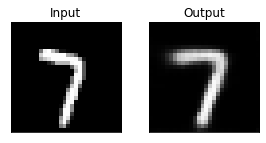

In [0]:
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(4,2))
idx = np.random.randint(0,10000,1)[0]

test = test_dataset[idx][0].unsqueeze(0).to(device)
with torch.no_grad():
    pred_test,_,_ = net(test)
axs[0].imshow(test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0].set_title('Input')
axs[1].imshow(pred_test.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1].set_title('Output')
for i in range(2):
  axs[i].set_xticks([])
  axs[i].set_yticks([])

plt.savefig(path+'outvae.png')
plt.tight_layout()
plt.show()

100%|██████████| 2000/2000 [00:30<00:00, 66.45it/s]


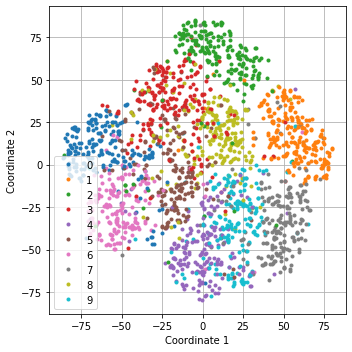

100%|██████████| 1000/1000 [00:14<00:00, 70.23it/s]


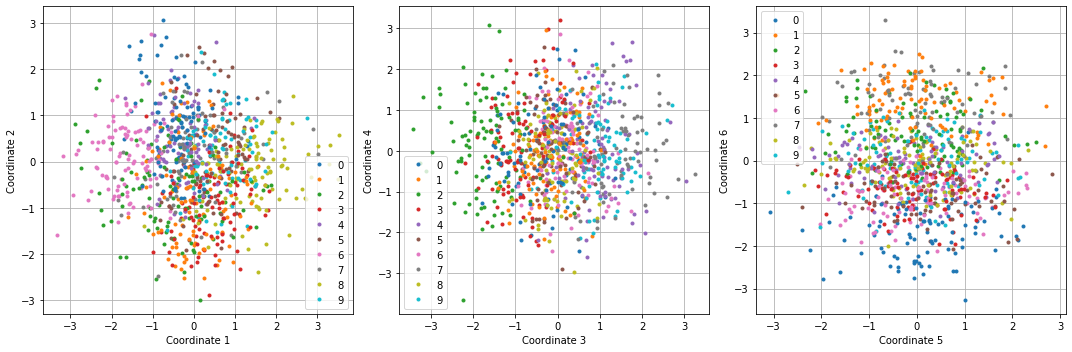

In [0]:
Space(net,True)

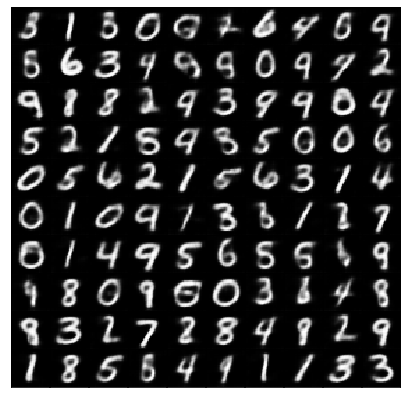

In [0]:
Generate(net,6,True)

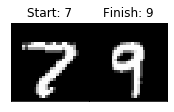

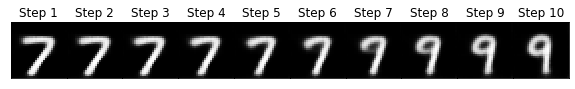

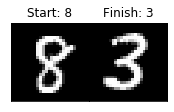

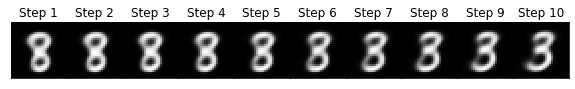

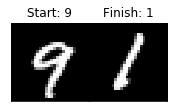

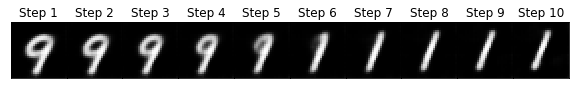

In [0]:
Transitions(net,7,9,True)
Transitions(net,8,3,True)
Transitions(net,9,1,True)

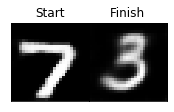

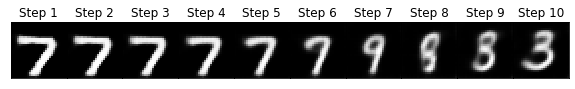

In [0]:
RandomTransitions(net,6,True)